##Downloading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d chiragsoni/ferdata

 96% 58.0M/60.3M [00:03<00:00, 29.9MB/s]
100% 60.3M/60.3M [00:03<00:00, 19.3MB/s]


In [ ]:
!unzip /content/ferdata.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

#Importing the Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from skimage.io import imread
from skimage.transform import rescale
from tensorflow.keras.preprocessing import image
from PIL import Image
from tqdm import tqdm
from keras.layers import Input, UpSampling2D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, InceptionV3, MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from keras.preprocessing import image
import os
sns.set()

#Loading the Dataset

##Loading Training Data

In [ ]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     width_shift_range = 0.1,
     height_shift_range = 0.1,
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/train",
                                               target_size=(128,128),
                                               batch_size=32,
                                               class_mode='categorical',
                                  )


train_data.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

##Loading Test Dataset

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/test",
                                           target_size=(128,128),
                                           batch_size=32,
                                           class_mode='categorical',
                                  )

val_data.class_indices

Found 7178 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

#Visualization of Emotion Category Distribution in Training Data

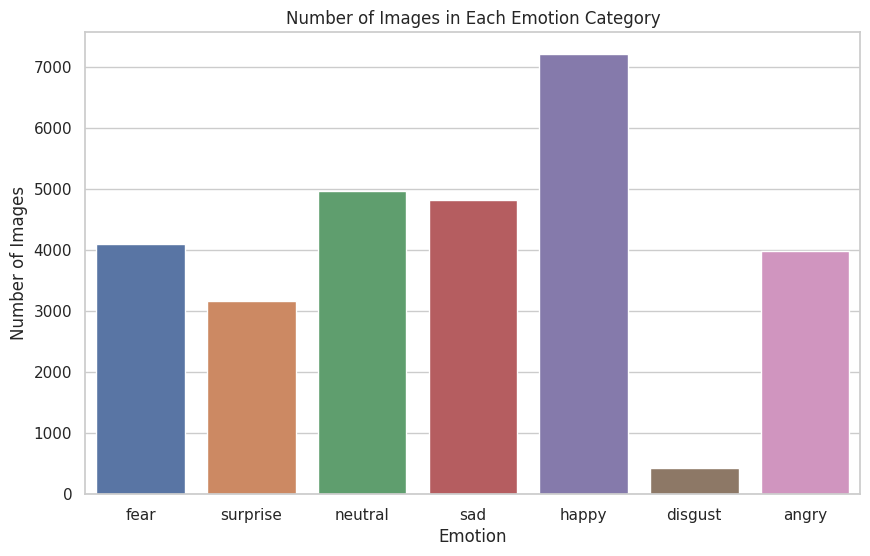

In [ ]:
path = '/content/train'

emotions = os.listdir(path)

folder_names = []
counts = []

for emotion in emotions:
    emotion_path = os.path.join(path, emotion)
    num_images = len(os.listdir(emotion_path))

    folder_names.append(emotion)
    counts.append(num_images)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=folder_names, y=counts)
ax.set(xlabel='Emotion', ylabel='Number of Images')
plt.title('Number of Images in Each Emotion Category')
plt.show()

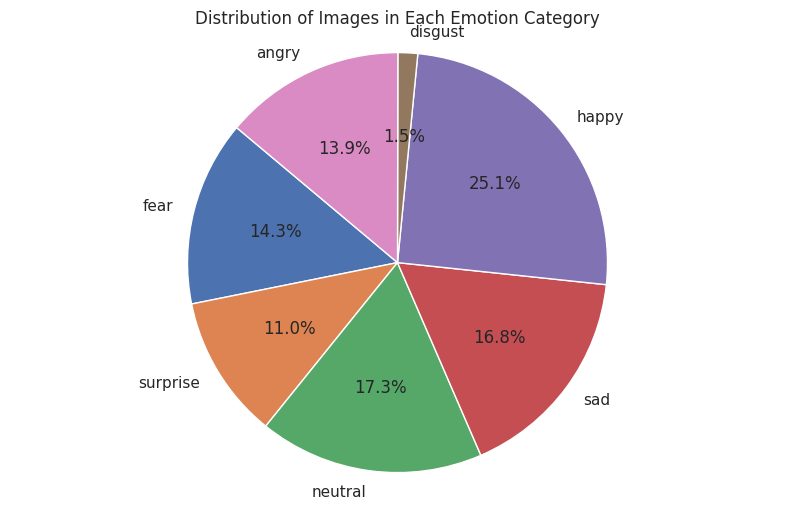

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(counts, labels=folder_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images in Each Emotion Category')
plt.axis('equal')
plt.show()

#Visualization of Sample Images from Training Data

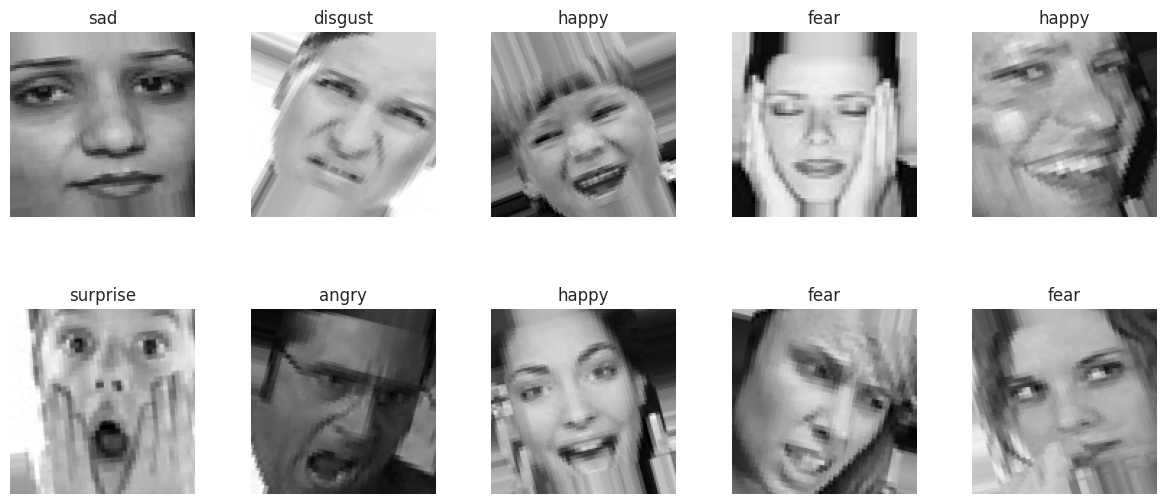

In [ ]:
t_img , label = train_data.next()

def plotImages(img_arr, one_hot_labels, label_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.5)

    for i, (im, one_hot_label) in enumerate(zip(img_arr, one_hot_labels)):
        label_index = np.argmax(one_hot_label)
        label_name = label_names[label_index]

        ax = axes[i // 5, i % 5]
        ax.imshow(im)
        ax.set_title(label_name)
        ax.axis('off')

        if i == 9:
            break

label_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plotImages(t_img, label, label_names)

#Deep Learning

## Traansfer Learning(TL)

###MobileNet-based CNN Model

In [ ]:
base_model = MobileNet( weights = 'imagenet', input_shape = (128,128,3), include_top = False )

x = base_model.output
x= Conv2D(filters = 32, kernel_size = (1,1), strides = (1,1), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)

x= GlobalAveragePooling2D()(x)

x = Flatten()(x)

x = Dense(units = 256 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units = 512 , activation = 'relu' )(x)
x= Dropout(0.3)(x)

x = Dense(units=7 , activation = 'softmax' )(x)

model = Model(base_model.input, outputs = x)

model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy']  )
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 64, 64, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 64, 64, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 64, 64, 32)        128 

###Model Training with Callbacks

In [ ]:
checkpoint = ModelCheckpoint(filepath="best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [ ]:
hist = model.fit(train_data, epochs = 25, validation_data = val_data, callbacks = callbacks_list, verbose=2)

Epoch 1/25

Epoch 1: val_accuracy improved from -inf to 0.49025, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 - 187s - loss: 1.5225 - accuracy: 0.3985 - val_loss: 1.3517 - val_accuracy: 0.4902 - lr: 0.0010 - 187s/epoch - 417ms/step
Epoch 2/25

Epoch 2: val_accuracy improved from 0.49025 to 0.49401, saving model to best_model.h5
449/449 - 155s - loss: 1.3187 - accuracy: 0.4994 - val_loss: 1.3496 - val_accuracy: 0.4940 - lr: 0.0010 - 155s/epoch - 346ms/step
Epoch 3/25

Epoch 3: val_accuracy improved from 0.49401 to 0.53957, saving model to best_model.h5
449/449 - 157s - loss: 1.2388 - accuracy: 0.5332 - val_loss: 1.1967 - val_accuracy: 0.5396 - lr: 0.0010 - 157s/epoch - 350ms/step
Epoch 4/25

Epoch 4: val_accuracy improved from 0.53957 to 0.56199, saving model to best_model.h5
449/449 - 155s - loss: 1.1834 - accuracy: 0.5573 - val_loss: 1.1565 - val_accuracy: 0.5620 - lr: 0.0010 - 155s/epoch - 346ms/step
Epoch 5/25

Epoch 5: val_accuracy improved from 0.56199 to 0.57509, saving model to best_model.h5
449/449 - 161s - loss: 1.1435 - accuracy: 0.5717 - val_loss: 1.1188 - val_accuracy: 0.57

In [ ]:
#model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Emotion_Detection.h5')
model = load_model('/content/drive/MyDrive/Colab_Notebooks/DL Model/Emotion_Detection.h5')

###Training and Validation Metrics Visualization

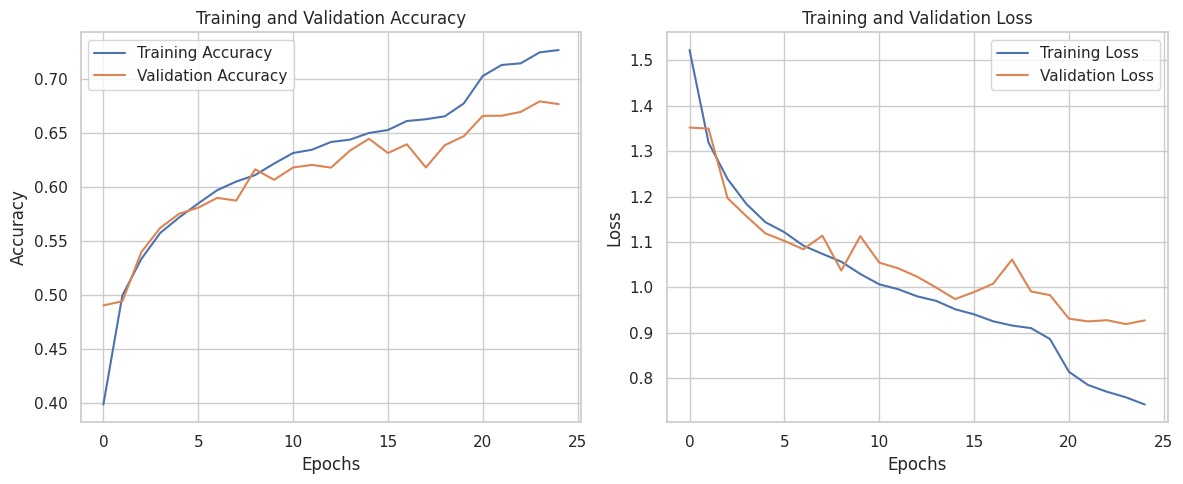

In [ ]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

###Evaluation of the Model

In [ ]:
results = model.evaluate(val_data, verbose=True)

loss = round(results[0], 2)
accuracy = round(results[1] * 100, 2)

print(f'Test results - Loss: {loss} - Accuracy: {accuracy}%')

113/113 [==============================] - 7s 61ms/step - loss: 0.9273 - accuracy: 0.6765
Test results - Loss: 0.93 - Accuracy: 67.65%


###Model Prediction on Test Images

In [ ]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


1/1 [==============================] - 0s 22ms/step
/content/test/neutral/PrivateTest_11239107.jpg 
The image is of neutral.

1/1 [==============================] - 0s 23ms/step
/content/test/disgust/PrivateTest_89077668.jpg 
The image is of disgust.

1/1 [==============================] - 0s 22ms/step
/content/test/angry/PrivateTest_10590091.jpg 
The image is of angry.

1/1 [==============================] - 0s 23ms/step
/content/test/fear/PrivateTest_1161501.jpg 
The image is of fear.



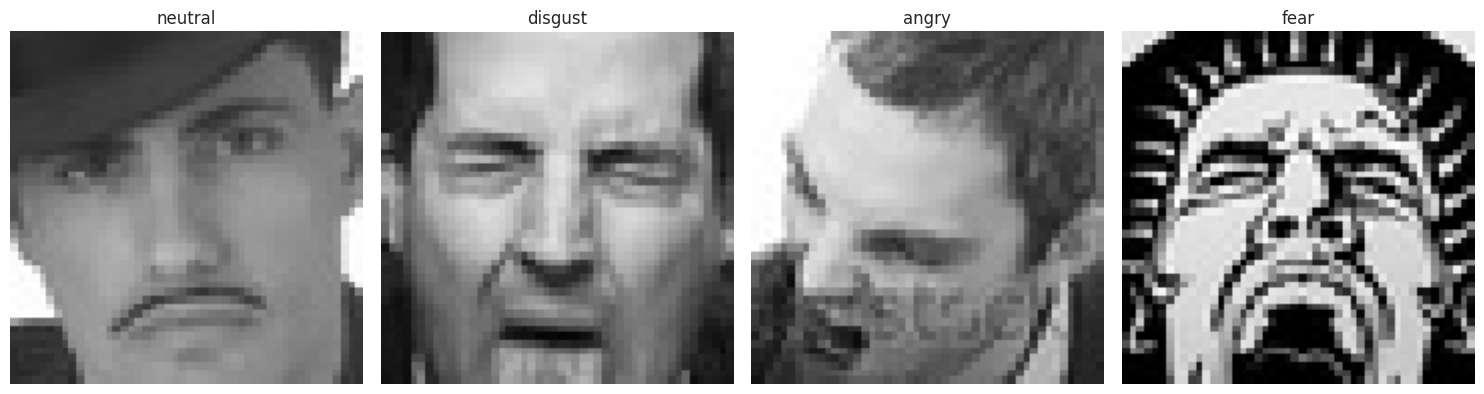

In [ ]:
image_paths = [
    '/content/test/neutral/PrivateTest_11239107.jpg',
    '/content/test/disgust/PrivateTest_89077668.jpg',
    '/content/test/angry/PrivateTest_10590091.jpg',
    '/content/test/fear/PrivateTest_1161501.jpg'
]

num_images = len(image_paths)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, path in enumerate(image_paths):
    img = load_img(path, target_size=(128, 128))
    img_arr = img_to_array(img) / 255
    input_arr = np.array([img_arr])
    pred = np.argmax(model.predict(input_arr))
    print(f"{path} \nThe image is of {op[pred]}.\n")

    axs[i].imshow(img_arr)
    axs[i].set_title(op[pred])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

##Convolutional Neural Network (CNN)

###CNN Model

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(filters = 128, kernel_size = (1,1), input_shape = [128,128,3]))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Conv2D(filters = 256, kernel_size = (3,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Conv2D(filters = 512, kernel_size = (3,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Flatten())

model_cnn.add(Dense(units = 256))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 512))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 1024))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 7, activation = 'softmax'))

model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     512       
                                                                 
 activation (Activation)     (None, 128, 128, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 256)       295168    
                                                                 
 activation_1 (Activation)   (None, 62, 62, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 256)       0         
 g2D)                                                   

###Model Training with Callbacks

In [ ]:
hist_cnn = model_cnn.fit(train_data, epochs = 25, validation_data = val_data, callbacks = callbacks_list, verbose=2)

Epoch 1/25

Epoch 1: val_accuracy improved from -inf to 0.31875, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 - 209s - loss: 1.7865 - accuracy: 0.2623 - val_loss: 1.6862 - val_accuracy: 0.3188 - lr: 0.0010 - 209s/epoch - 232ms/step
Epoch 2/25

Epoch 2: val_accuracy improved from 0.31875 to 0.38130, saving model to best_model.h5
898/898 - 175s - loss: 1.6843 - accuracy: 0.3206 - val_loss: 1.5554 - val_accuracy: 0.3813 - lr: 0.0010 - 175s/epoch - 195ms/step
Epoch 3/25

Epoch 3: val_accuracy improved from 0.38130 to 0.42226, saving model to best_model.h5
898/898 - 178s - loss: 1.5810 - accuracy: 0.3754 - val_loss: 1.4725 - val_accuracy: 0.4223 - lr: 0.0010 - 178s/epoch - 199ms/step
Epoch 4/25

Epoch 4: val_accuracy improved from 0.42226 to 0.42979, saving model to best_model.h5
898/898 - 177s - loss: 1.5048 - accuracy: 0.4110 - val_loss: 1.4275 - val_accuracy: 0.4298 - lr: 0.0010 - 177s/epoch - 197ms/step
Epoch 5/25

Epoch 5: val_accuracy improved from 0.42979 to 0.46573, saving model to best_model.h5
898/898 - 180s - loss: 1.4466 - accuracy: 0.4388 - val_loss: 1.3705 - val_accuracy: 0.46

###Training and Validation Metrics Visualization

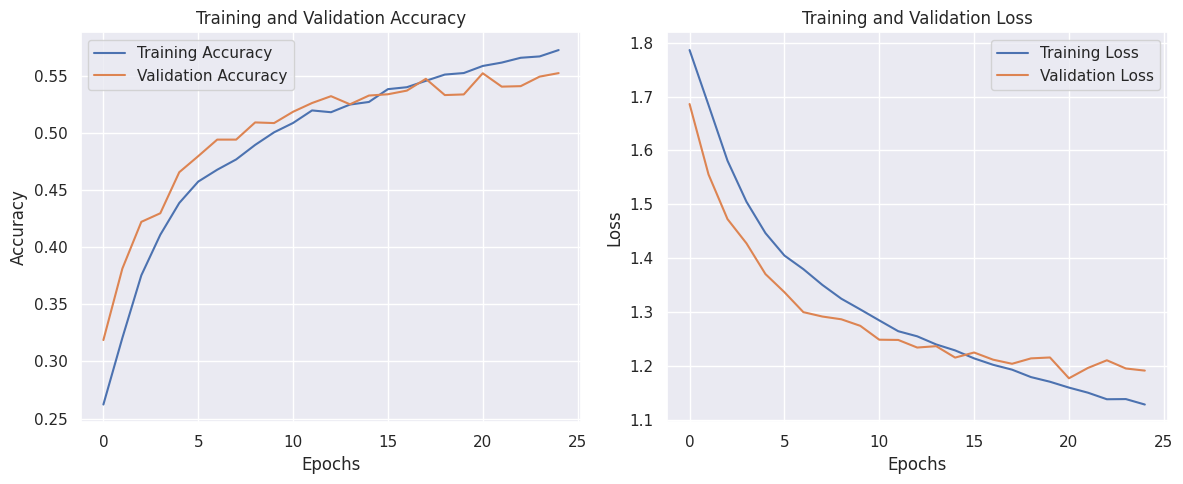

In [ ]:
train_acc = hist_cnn.history['accuracy']
val_acc = hist_cnn.history['val_accuracy']
train_loss = hist_cnn.history['loss']
val_loss = hist_cnn.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

###Evaluation of the Model on Validation Data

In [ ]:
results = model_cnn.evaluate(val_data, verbose=True)

loss = round(results[0], 2)
accuracy = round(results[1] * 100, 2)

print(f'Test results - Loss: {loss} - Accuracy: {accuracy}%')

225/225 [==============================] - 8s 35ms/step - loss: 1.1912 - accuracy: 0.5525
Test results - Loss: 1.19 - Accuracy: 55.25%


###Model Prediction on Test Images

In [ ]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
1/1 [==============================] - 0s 318ms/step
/content/test/neutral/PrivateTest_11239107.jpg 
The image is of neutral.

1/1 [==============================] - 0s 22ms/step
/content/test/disgust/PrivateTest_89077668.jpg 
The image is of angry.

1/1 [==============================] - 0s 21ms/step
/content/test/angry/PrivateTest_10590091.jpg 
The image is of neutral.

1/1 [==============================] - 0s 23ms/step
/content/test/fear/PrivateTest_1161501.jpg 
The image is of fear.



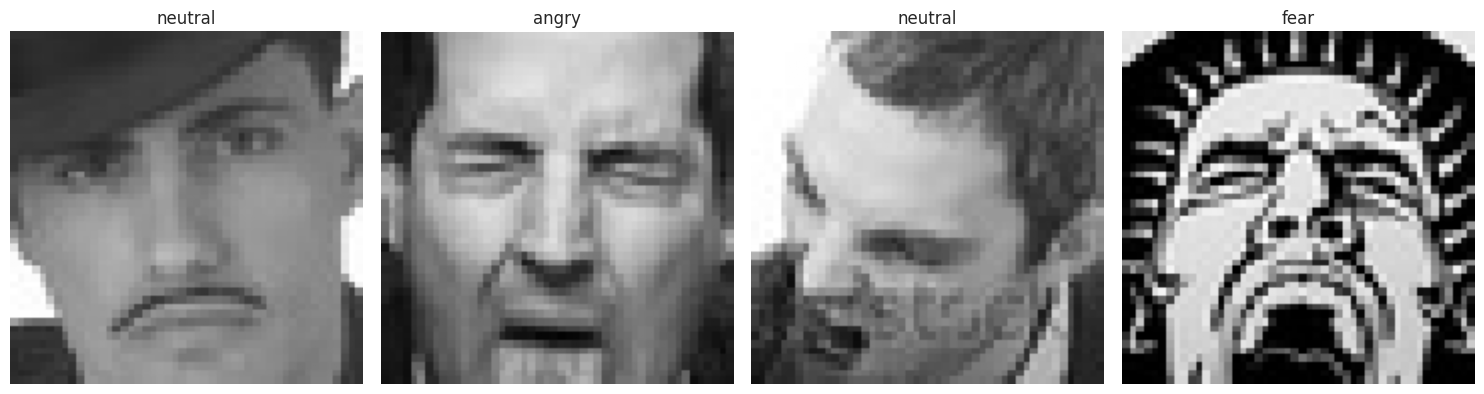

In [ ]:
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
print(op)

image_paths = [
    '/content/test/neutral/PrivateTest_11239107.jpg',
    '/content/test/disgust/PrivateTest_89077668.jpg',
    '/content/test/angry/PrivateTest_10590091.jpg',
    '/content/test/fear/PrivateTest_1161501.jpg'
]

num_images = len(image_paths)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

for i, path in enumerate(image_paths):
    img = load_img(path, target_size=(128, 128))
    img_arr = img_to_array(img) / 255
    input_arr = np.array([img_arr])
    pred = np.argmax(model_cnn.predict(input_arr))
    print(f"{path} \nThe image is of {op[pred]}.\n")

    axs[i].imshow(img_arr)
    axs[i].set_title(op[pred])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

#Real-time Emotion Detection using a Webcam (Doesn't work on Colab but works on a local device)

In [ ]:
face_classifier = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')
classifier =load_model(r'Emotion_Detection.h5')

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']

cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(224,224),interpolation=cv2.INTER_AREA)
        roi = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)
        roi = roi.astype('float')/255.0
        roi = np.expand_dims(roi,axis=0)

        prediction = classifier.predict(roi)[0]
        label=emotion_labels[prediction.argmax()]
        label_position = (x,y)
        cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()